# Rozpoznawanie obrazu na potrzeby eksperymentu naukowego

Pi of the Sky (https://www.pi.fuw.edu.pl/jest) jest eksperymentem astrofizycznym, którego głównym celem jest poszukiwanie rozbłysków gamma (GRB) (https://pl.wikipedia.org/wiki/Rozbłysk_gamma). W tym celu zautomatyzowane teleskopy w Chile i Hiszpanii fotografują niebo w poszukiwaniu interesujących zdarzeń. Klasyczne algorytmy wykrywania rozbłysków gamma działają w następujący sposób: wybrany obszar nieba jest stale fotografowany w pewnych odstępach czasu, jeżeli skanowany obszar zmieni się w jakiś sposób, może to oznaczać, iż pojawiło się nowe źródło promieniowania, dlatego kilka(naście) klatek (zdjęć) przed i po wystąpieniu zjawiska jest zachowywanych do późniejszej analizy. Naukowcy analizują sekwencję zdjęć aby stwierdzić, czy faktycznie zaobserwowano rozbłysk gamma. Niestety, wiele spośród zebranych danych to fałszywe alarmy, wywołane np. przez chmury poruszające się na niebie. Celem pracy jest stworzenie algorytmu uczenia maszynowego opartego o konwolucyjne sieci neuronowe, który mógłby usprawnić analizę poprzez odsiewanie niepoprawnych danych, oszczędzając pracy naukowcom.

 Jest to jedynie "proof of concept" pokazujący, że problem może potencjalnie zostać rozwiązany z użyciem zaproponowanej metody. Program jest ograniczony do analizy pojedynczych obrazów a nie całych sekwencji. Dokonuje klasyfikacji obrazów należących do trzech klas:

0) zdjęcia potencjalnie zawierające rozbłyski gamma 

1) fałszywe alarmy przedstawiające niebo z chmurami

2) fałszywe alarmy zawierające artefakty spowodowane wadliwą pracą aparatury badawczej (poziome/pionowe linie)

dane:

---
dane znajdują się w archiwum "data.zip":

 https://github.com/Rav2/uczenie-maszynowe-2021-22/raw/main/praca_domowa/data.zip

folder "data" zawiera trzy podfoldery odpowiadające trzem klasom: "0", "1" oraz "2", które zawierają obrazki w formacie JPG

wszystkie obrazki mają identyczne wymiary

# importy


In [1]:
!pip install bayesian-optimization

In [2]:
import sys, os

from termcolor import colored
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import cm

import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.python.keras.optimizer_v2 import rmsprop

from bayes_opt import BayesianOptimization

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


# Rozwiązanie

## wczytanie i wstępna obróbka danych

### pobranie i rozpakowanie danych

In [3]:
# Odkomentuj i wykonaj, żeby pobrać dane i rozpakować
! wget https://github.com/Rav2/uczenie-maszynowe-2021-22/raw/main/praca_domowa/data.zip
! unzip -q data.zip

--2022-02-06 16:01:56--  https://github.com/Rav2/uczenie-maszynowe-2021-22/raw/main/praca_domowa/data.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Rav2/uczenie-maszynowe-2021-22/main/praca_domowa/data.zip [following]
--2022-02-06 16:01:56--  https://raw.githubusercontent.com/Rav2/uczenie-maszynowe-2021-22/main/praca_domowa/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14050616 (13M) [application/zip]
Saving to: ‘data.zip.4’

data.zip.4          100%[===================>]  13.40M  --.-KB/s    in 0.1s    

2022-02-06 16:01:56 (121 MB/s) - ‘data.zip.4’ saved [14050616/14050616

### wczytanie obrazków

---

* utorzenie tensora cech X i wektora etykiet y.
* tensor cech ma mieć wymiar (3573, 100, 100, 1). 1 odpowiada pojedynczemu kanałowi (czarno-biały obraz) 

In [5]:
X = np.zeros((3573,100,100))
y = np.zeros(3573)

ind = 0

for j in range(3):
    #wczytanie obrazków
    files = os.listdir('data/{}/'.format(j))
    for i in range(np.shape(files)[0]):
        if files[i].split('.')[1]=='jpg': #biorę pod uwagę tylko pliki w formacie jpg
            path = os.path.join('data/{}/'.format(j), files[i])
            img=load_img(path, color_mode='grayscale')
            img_arr = np.asarray(img)
            #utorzenie tensora cech X i wektora etykiet y
            X[ind]=img_arr
            y[ind]=j
            ind+=1

print(np.shape(X))
print(np.shape(y))

(3573, 100, 100)
(3573,)


In [6]:
X = X.reshape(X.shape+(-1,))
print(np.shape(X))

(3573, 100, 100, 1)


### sprawdzenie danych

 --- 
* sprawdzenie liczebność klas
* sprawdzenie wymiarów obrazka (w pikselach) 

In [7]:
for i in range(3):
    print('Liczebność klasy {}: {}'.format(i,np.sum(y==i)))

Liczebność klasy 0: 1978
Liczebność klasy 1: 706
Liczebność klasy 2: 889


In [8]:
print('Wymiary obrazka: {}x{}'.format(X.shape[1],X.shape[2]))

Wymiary obrazka: 100x100


### przykładowe obrazy dla każdej z klas

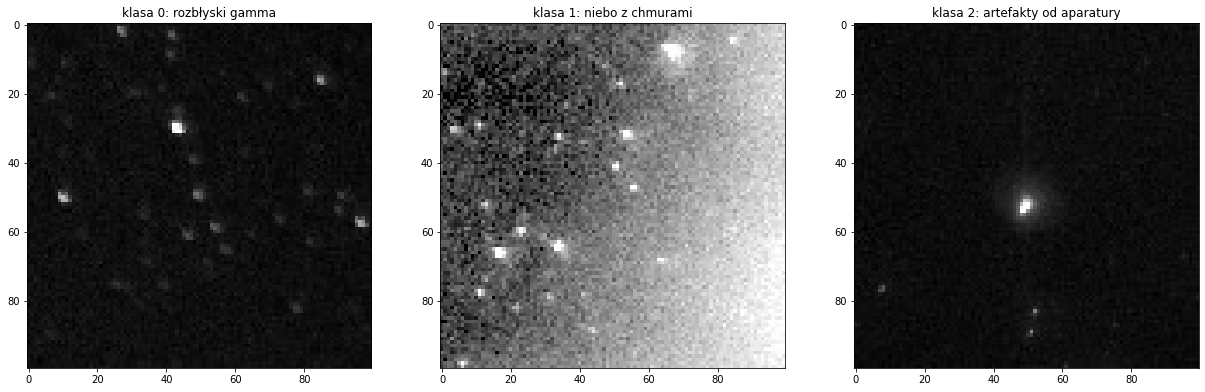

In [9]:
titles = ['rozbłyski gamma','niebo z chmurami','artefakty od aparatury']

plt.rcParams['figure.figsize']=(21,10)
for i in range(3):
    plt.subplot(1,3,i+1)
    ind = np.where(y==i)[0]
    plt.imshow(X[ind[1]][:,:,0],cmap=cm.gray)
    plt.title('klasa '+str(i)+': '+titles[i])

## preprocessing

* przeskalowanie wartości pikseli do przedziału [0,1]

In [10]:
maxValue = np.amax(X)
X/=maxValue

* podział danych na zbiory uczący (70%) i testowy (30%).

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

* sprawdzenie czy rozkład klas w obu zbiorach jest zbliżony - żeby takie same proporcje klas występowały w zbiorze treningowym i testowym

In [31]:
klasy=[]
n=np.shape(y_train)[0]
for i in range(3):
    klasy.append(np.sum(y_train==i))
print('stosunek ilośći przykładów dla zbioru y_train:  {} : {} : {}'.format(klasy[0],klasy[1],klasy[2]))
print('udzial w danych: {} : {} : {}'.format(round(klasy[0]/n, 2),round(klasy[1]/n,2),round(klasy[2]/n,2)))

print(' ')

klasy=[]
n=np.shape(y_test)[0]
for i in range(3):
    klasy.append(np.sum(y_test==i))
print('stosunek ilośći przykładów dla zbioru y_test:  {} : {} : {}'.format(klasy[0],klasy[1],klasy[2]))
print('udzial w danych: {} : {} : {}'.format(round(klasy[0]/n, 2),round(klasy[1]/n,2),round(klasy[2]/n,2)))


stosunek ilośći przykładów dla zbioru y_train:  1384 : 479 : 638
udzial w danych: 0.55 : 0.19 : 0.26
 
stosunek ilośći przykładów dla zbioru y_test:  594 : 227 : 251
udzial w danych: 0.55 : 0.21 : 0.23


* zmiana reprezentacji etykiet

In [32]:
depth = 3
y_train = tf.one_hot(y_train,depth)
y_test = tf.one_hot(y_test,depth)

## uczenie sieci i ewaluacja

In [14]:
nFilters = 32
kernel_size = 3
pool_size = (2,2)
nNeurons = 128 
nHiddenLayers = 1 
dropout_rate = 0.2
inputShape = (100, 100, 1)
outputWidth = 3

### funkcje

In [15]:
def printScores(model, X_test, y_test):
    Y_pred = np.argmax(model.predict(X_test), axis=1)
    Y_test=np.argmax(y_test, axis=1)
    #accuracy
    acc=accuracy_score(Y_test,Y_pred) # dokładność
    print('Accuracy: ',acc)
    # classification_report() żeby policzyć najpopularniejsze miary 
    print("Classification report:")
    print(classification_report(Y_test,Y_pred))
    # macierz pomyłek 
    print("Confusion matrix:")
    confusion = confusion_matrix(Y_test, Y_pred)
    print(confusion)
    return confusion

In [28]:
def plotTrainingHistory(model):

    fig, axes= plt.subplots(1,2,figsize=(10,5))
    history = model.history
    axes[0].plot(history['accuracy'])
    axes[0].plot(history['val_accuracy'])
    axes[0].set_ylim(0.7,1)
    axes[0].set_title('accuracy plot')
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'validation'], loc='upper left')

    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_ylim(0,0.5)
    axes[1].set_title('loss function plot')
    axes[1].set_ylabel('loss function')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['train', 'validation'], loc='upper left')  

### propozycja architektury sieci opartej o warstwy CNN

---

* sieć przyjmuje obrazki w oryginalnych rozmiarach.
* 15% ze zbioru uczącego zostaje wydzielone na walidację.


In [17]:
%%time 

def getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, inputShape, outputWidth):

    model = keras.Sequential()
    model.add(tf.keras.Input(shape=inputShape))

    for iHidden in range(nHiddenLayers):
        model.add(Conv2D(filters=nFilters, 
                         kernel_size=kernel_size,
                         activation=tf.nn.relu)
        )
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Dropout(dropout_rate))
  
    model.add(Flatten())
    model.add(Dense(nNeurons,
                    activation=tf.nn.relu)
    )
    
    model.add(Dense(outputWidth,
                    activation=tf.nn.softmax)
    )
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


model_basic = getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, inputShape, outputWidth)

epochs = 15
batch_size = 128

model_basic_fit = model_basic.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.15,verbose=0)

CPU times: user 8.35 s, sys: 1.2 s, total: 9.55 s
Wall time: 21.9 s


### ewaluacja

---
* wykresy accuracy i funkcji kosztu w funkcji numeru epoki (iteracji) uczenia, zarówno dla zbioru uczącego jak i walidacyjnego
* dokonanie predykcji na zbiorze testowym wraz z wypisanym raportem klasyfikacji i macierzą pomyłek
* obliczenie % poprawnie sklasyfikowanych obrazków dla każdej z klas wraz z histogramem


Accuracy:  0.9869402985074627
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       611
           1       0.96      1.00      0.98       215
           2       0.99      0.96      0.97       246

    accuracy                           0.99      1072
   macro avg       0.98      0.98      0.98      1072
weighted avg       0.99      0.99      0.99      1072

Confusion matrix:
[[608   0   3]
 [  0 215   0]
 [  1  10 235]]


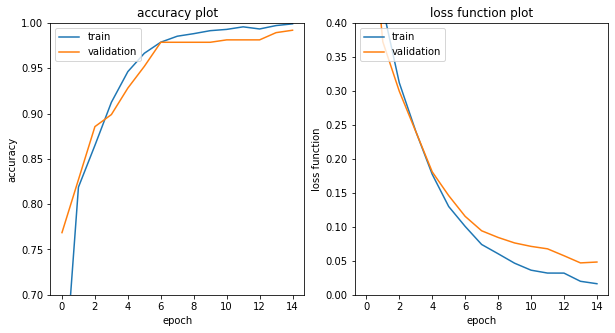

In [18]:
confusion=printScores(model_basic, X_test, y_test)
plotTrainingHistory(model_basic_fit)  

#### histogram poprawnych klasyfikacji

Text(0, 0.5, 'procent poprawnie skalsyfikowanych obrazków')

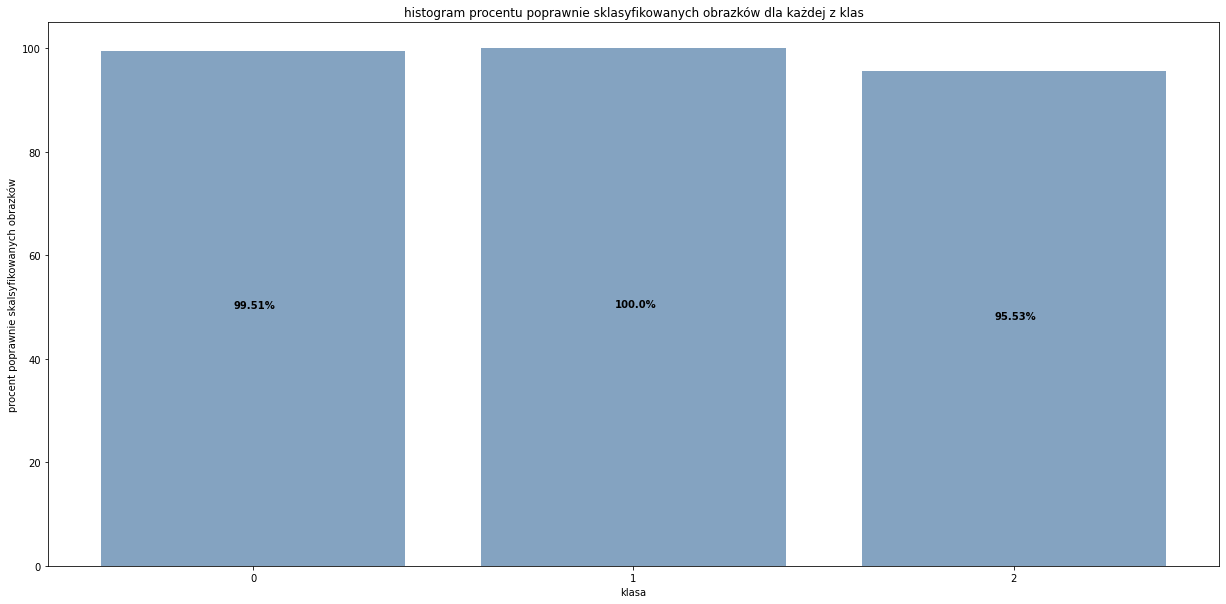

In [19]:
percent=[np.round(confusion[i][i]/np.sum(confusion[i])*100,2) for i in range(3)]
ind = np.arange(3)

from matplotlib.ticker import MaxNLocator

plt.rcParams['figure.figsize']=(21,10)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.bar(ind,percent,color=(0.2, 0.4, 0.6, 0.6))
for i, v in enumerate(percent):
    ax.text(i-.05,v/2, str(v)+'%', color='black', fontweight='bold')
ax.set_title('histogram procentu poprawnie sklasyfikowanych obrazków dla każdej z klas')
ax.set_xlabel('klasa')
ax.set_ylabel('procent poprawnie skalsyfikowanych obrazków')

#### krzywa ROC 

wraz z policzoną AUC

na podstawie:

 https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [20]:
y_pred = model_basic.predict(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

ROC dla wielu klas

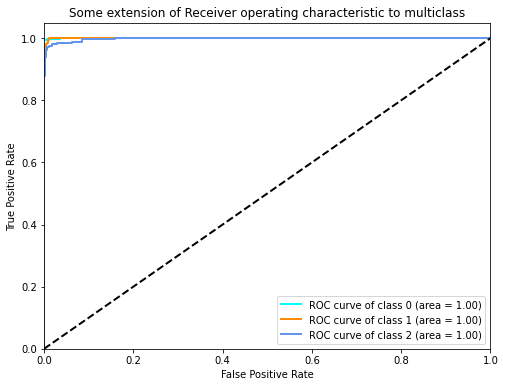

In [21]:
from itertools import cycle

#plot ROC curves
plt.rcParams['figure.figsize']=(8,6)
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(3), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## Generacja pseudodanych


praca z tensorflow.keras.preprocessing.image.ImageDataGenerator

---
    
* stworzenie obiektu typu ImageDataGenerator z parametrami pozwalającymi na generację pseudodanych poprzez użycie: 

        a) przesunięcia o nie wiecej niż 20 pikseli 
        b) odbicia względem osi OX lub OY 
        c) zoom do 10%

* 15% ze zbioru uczącego zostaje wydzielone na walidację.

* trening sieci z wykorzystaniem z metody flow dla obiektu typu ImageDataGenerator 

* ponowna ewaluację sieci wytrenowanej z generacją pseudodanych.


In [22]:
model_2 = getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, inputShape, outputWidth)

In [23]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=20,
                                                          height_shift_range=20, #przesunięcie 20 pikseli 
                                                          zoom_range=0.1, #zoom do 10%
                                                          horizontal_flip=True, #odbicia względem osi OX 
                                                          vertical_flip=True, #odbicia względem osi OY 
                                                          validation_split=0.15) #15% na walidację
train_generator = datagen.flow(X_train,
                               y_train,
                               batch_size=batch_size,
                               subset='training')
validation_generator = datagen.flow(X_train, 
                                    y_train, 
                                    batch_size=int(batch_size/4), 
                                    subset='validation')

In [24]:
%%time 

model_2_fit=model_2.fit(train_generator, 
                        epochs=epochs,
                        validation_data=validation_generator, 
                        verbose=0)

CPU times: user 39.5 s, sys: 487 ms, total: 40 s
Wall time: 38.5 s


### ewaluacja

---
* wykresy accuracy i funkcji kosztu w funkcji numeru epoki (iteracji) uczenia, zarówno dla zbioru uczącego jak i walidacyjnego
* dokonanie predykcji na zbiorze testowym wraz z wypisanym raportem klasyfikacji i macierzą pomyłek
* obliczenie % poprawnie sklasyfikowanych obrazków dla każdej z klas wraz z histogramem


Accuracy:  0.8208955223880597
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.99      0.87       611
           1       0.99      0.93      0.96       215
           2       0.79      0.30      0.43       246

    accuracy                           0.82      1072
   macro avg       0.85      0.74      0.76      1072
weighted avg       0.83      0.82      0.79      1072

Confusion matrix:
[[606   0   5]
 [  0 201  14]
 [171   2  73]]


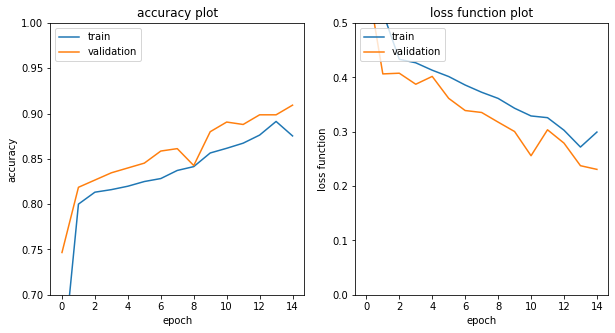

In [29]:
confusion=printScores(model_2, X_test, y_test)
plotTrainingHistory(model_2_fit)  

#### histogram poprawnych klasyfikacji

Text(0, 0.5, 'procent poprawnie skalsyfikowanych obrazków')

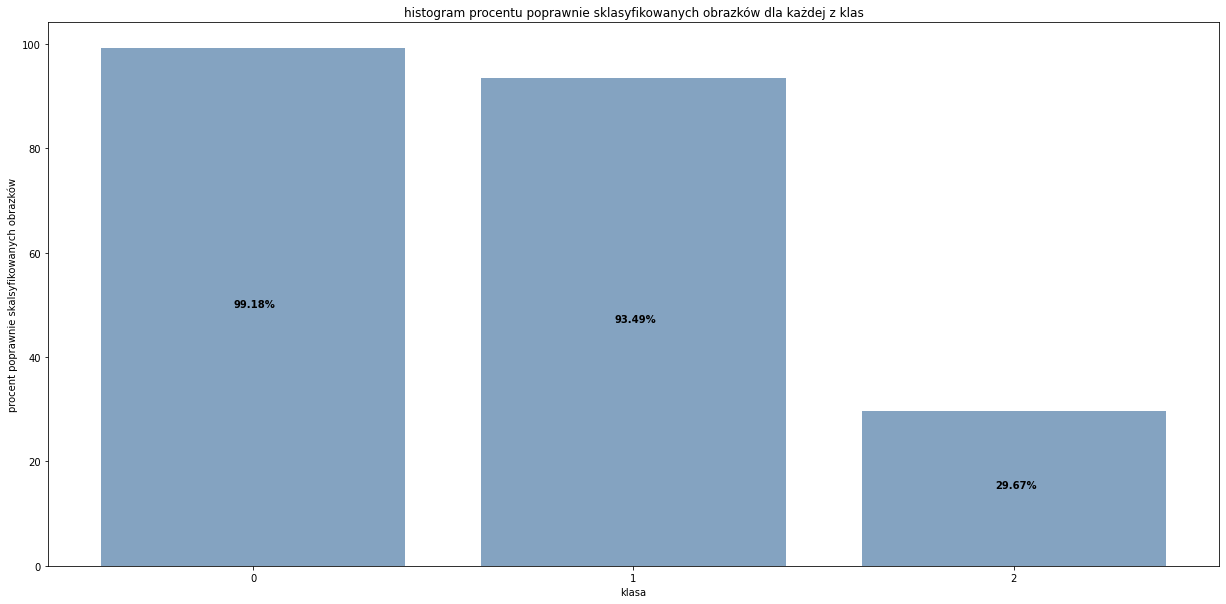

In [26]:
percent=[np.round(confusion[i][i]/np.sum(confusion[i])*100,2) for i in range(3)]
ind = np.arange(3)

from matplotlib.ticker import MaxNLocator

plt.rcParams['figure.figsize']=(21,10)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.bar(ind,percent,color=(0.2, 0.4, 0.6, 0.6))
for i, v in enumerate(percent):
    ax.text(i-.05,v/2, str(v)+'%', color='black', fontweight='bold')
ax.set_title('histogram procentu poprawnie sklasyfikowanych obrazków dla każdej z klas')
ax.set_xlabel('klasa')
ax.set_ylabel('procent poprawnie skalsyfikowanych obrazków')

#### krzywa ROC 

wraz z policzoną AUC

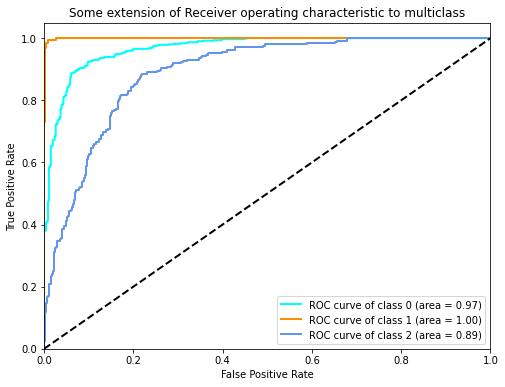

In [27]:
y_pred = model_2.predict(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#plot ROC curves
plt.rcParams['figure.figsize']=(8,6)
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(3), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## podsumowanie

---


Podstawowy model sieci neuronowej zbudowany z 3 warstw CNN (konwolucja, pooling, dropout) bardzo dobrze poradził sobie z klasyfikacją - uzyskał on 99% dokładność na danych testowych. 

Model poszerzony o generację pseudodanych dał znacznie gorsze wyniki niż model podstawowy. Fakt gorszej klasyfikacji potwierdzają wykresy dokładności i funkcji kosztu:
* dla pierwszego modelu są one bardziej przewidywalne i mają odpowiednio większe i mniejsze wartości przy wyższych epokach, na oko:
 * acc między 0.97 a 1.00, 
 * loss między 0.00 a 0.07
* dla modelu z generacją otrzymują gorze miary i są mniej przewidywalne, na oko:
 * acc między 0.85 a 0.90, 
 * loss między 0.25 a 0.30

Obserwując histogramy sieci przed i po generacji danych można zauważyć, że klasy 0 i 1 mają bardzo podobne wyniki procentowe, podczas gdy dla klasy 2 poprawna ilość precykcji znacząco spadła. W macierzy pomyłek widać, że większość obrazków pochodzących z klasy 2 została błędnie przypisana do klasy 0. 

> Prawdopodobnie wynika to z faktu, że podstawowa sieć nauczyła się rozpoznawać na zdjęciach klasy 2 pionowe kreski w połowie obrazu (występujące na większości zdjęć) i a tej podstawie klasyfikowała je jako zdjęcia z artefaktami aparatury. W sieci z generacją w wyniku odbić i przesunięć linie zmieniły swoje położenie i przestały być pobudzeniem sieci. Ze względu na swoją chaotyczność zaczęły być traktowane jako artefakty nie mające wpływu na predykcję klasy

Co ciekawe, wartość AUC dla klasy 2 nie spadła aż tak drastycznie. Możliwe że wynika to z teoretycznej budowy krzywej ROC - bardziej tolerancyjnej niż metoda wybierania największego prawdopodobieństwa funkcją argmax.